In [ ]:
# 이것저것 import
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud.wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# mecab 설치 코드
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd 'Mecab-ko-for-Google-Colab'
!bash install_mecab-ko_on_colab_light_220429.sh


# Okt, Mecab 객체 생성
from konlpy.tag import Okt, Mecab
okt = Okt()
mecab = Mecab()


# 한글 폰트 설치 코드
!apt-get updata -qq
!apt-get install fonts-nanum* -qq

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 37.2 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-06-08 05:18:04--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00:

In [ ]:
# 구글 서버와 드라이브 연결 및 작업 디렉토리 변경
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/KDT/세미프로젝트'

Mounted at /content/drive
/content/drive/MyDrive/KDT/세미프로젝트


In [ ]:
# df 생성
df = pd.read_csv('kr3_raw.tsv', sep = '\t')
df

,Region,Rating,Category,Review
0,인덕원,1,삼겹살 고기집,숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1,인덕원,1,삼겹살 고기집,고기가 정말 맛있었어요! 육즙이 가득있어서 너무 좋았아요\n일하시는분들 너무 친절하...
2,인덕원,1,순대국 찹쌀순대,"잡내없고 깔끔, 담백한 맛의 순대국이 순대국을 안 좋아하는 사람들에게도 술술 넘어갈..."
3,인덕원,1,순대국 찹쌀순대,고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다~~ 맛도 좋습니다\n다만 양념...
4,인덕원,1,순대국 찹쌀순대,순대국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요.\n\n그러나 ...
...,...,...,...,...
642408,평택,2,일식/중식/세계음식,"요즘, 핫하게,,,떠오르구 있는 중국집. ㅋ, 맥주의 여파루 속이 안좋지만 와봄. ..."
642409,평택,0,한식,원래 글 안쓰는데 이거는 정말 다른분들 위해서 써야할것같네요 방금 포장주문 해서 왔...
642410,평택,1,한식,"우리팀 단골집, 술먹고 다음 날 가면 푸짐하게 배불리 해장 할 수 있는곳, 주말도 ..."
642411,평택,2,카페/디저트,"원래는 평택에 있었는데, 연남동에도 최근에 생겨서 방문 했는데..진짜 줄이 어마어마..."


In [ ]:
# 누락 데이터 있나요?
df.isnull().sum()

Region       0
Rating       0
Category    24
Review       0
dtype: int64

In [ ]:
# 누락 데이터 없애기
data = df.dropna()
data.isnull().sum()

Region      0
Rating      0
Category    0
Review      0
dtype: int64

In [ ]:
# 긍정적 리뷰와 부정적 리뷰로 나누자
positive = data.loc[data['Rating'] == 1, ['Review']].reset_index(drop=True)
negative = data.loc[data['Rating'] == 0, ['Review']].reset_index(drop=True)

In [ ]:
print(positive)

                                                   Review
0       숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1       고기가 정말 맛있었어요! 육즙이 가득있어서 너무 좋았아요\n일하시는분들 너무 친절하...
2       잡내없고 깔끔, 담백한 맛의 순대국이 순대국을 안 좋아하는 사람들에게도 술술 넘어갈...
3       고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다~~ 맛도 좋습니다\n다만 양념...
4       순대국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요.\n\n그러나 ...
...                                                   ...
388542  가격대비 괜찮긴한데 가격을 자꾸 올리고 샐러드바 메뉴는 줄어드는 경향이 있어서 살짝...
388543  리뷰에직원이 친절하지않다더니 정말이네요 선불이라 만원짜리내고 기다리고있는데 거지동냥...
388544  송탄 미군부대 근처에 위치한 곳 원래 로컬맛집으로 되게 유명했는데 삼대천왕에 나온 ...
388545  집에서 40키로 정도 떨어져 있는 곳인데도 몇달에 한번은 이거 먹으러 일부러 갑니다...
388546  우리팀 단골집, 술먹고 다음 날 가면 푸짐하게 배불리 해장 할 수 있는곳, 주말도 ...

[388547 rows x 1 columns]


In [ ]:
def preprocess(data):
  my_split = []
  for pas in data.iloc:
    data = (pas['Review'])
    # split_data = re.sub('[#"+*!.,~]', '', data).split(' ')
    split_data = re.sub('[^가-힣]', ' ', data).split(' ')
    for i in split_data:
      if len(i) >= 2:
        my_split.append(i)
  return my_split

In [ ]:
my_positive = preprocess(positive)
my_negative = preprocess(negative)
print(len(my_positive))
print(len(my_negative))

11246893
1724311


In [ ]:
good_review = str(' '.join(my_positive))
print(good_review[:1000])
print('='*100)

bad_review = str(' '.join(my_negative))
print(bad_review[:1000])

숙성 돼지고기 전문점입니다 건물 모양 때문에 매장 모양도 특이하지만 쾌적한 편이고 살짝 레트로 감성으로 분위기 잡아놨습니다 모든 직원분들께서 전부 가능하다고 멘트 쳐주시며 고기는 초반 커팅까지는 구워주십니다 가격 저렴한 아니지만 맛은 준수합니다 등심덧살이 인상 깊었는데 구이로 별로일 알았는데 육향 짙고 얇게 저며 뻑뻑하지 않았습니다 하이라이트는 된장찌개 진짜 굿입니다 버터간장밥 골뱅이국수 나중에 맛봐야 것들은 남겨뒀습니다 고기가 정말 맛있었어요 육즙이 가득있어서 너무 좋았아요 일하시는분들 너무 친절하고 좋습니당 가격이 조금 있기는 하지만 그만한 맛이라고 생각 잡내없고 깔끔 담백한 맛의 순대국이 순대국을 좋아하는 사람들에게도 술술 넘어갈듯합니다 정식 메뉴를 시키면 가성비 좋게 찹쌀순대와 수육이 나오는데 아주 푸짐해요 해장하러갔는데 국물이 꼬소해서 소주를 시키게 되는 여튼 순대국이 일품입니다 송파에선 알아주는 터줏대감인듯 해요 고기 양이 푸짐해서 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 득뿍 있어서 간이 약간 수도 있으니 참고하세요 기본적으로 웨이팅있습니다 순대국 자체는 제가 먹어본 순대국밥집 중에서 안에는 들어요 그러나 양이 적은 공기밥 자체가 맛나지만은 않았던 식당 주위에 흡연자 분들로 인해 일부 담배냄샤가 유입되는 점은 단점이라고 할만 합니다 괜찮아요 가격대비 많고 무난한 식당이었네요 순대국은 푸짐한 느낌이고 개인적로는 순대국보다 찹쌀순대가 맛나요 순대를 시키면 국물이 서비스로 나옴 순대국밥에서 돼지 누린내가 나지 않고 깔끔하고 얼큰함 진한 국물에 건더기도 많음 김치도 맛있고 직원분들도 친절했음 가락동에 있는 유명한 순대국밥집이에요 양도많고 친절해서 일부러 찾아가요 맛있어요 항상가는 단골이에요 냄새도 안나고 구수해요 자리가 많아 웨이팅이 별로 없고 회전률이 빠른편입니다 개인적으로 순대보단 수육이 맛있었습니다 수육의 식감은 매우 부드러운 편이고 순대도 상당히 부드러운 식감이지만 함경도식 스타일은 저에게 맞는 같습니다 순대국은 무난하게 맛있는 

In [ ]:
good_review[:1000]

print(len(good_review))


48719050


In [ ]:
# nouns_goodreview_mecab = mecab.nouns(good_review)
# print(nouns_goodreview_mecab[:100])
# print('='*100)
# nouns_badreview_mecab = mecab.nouns(bad_review)
# print(nouns_badreview_mecab[:100])

# Mecab Nonetype 에러 발생. 원인은 잘 모르겠음....
# ==>> Okt로 변경.

In [ ]:
# 명사로 변환
# nouns_goodreview_okt = okt.nouns(good_review[:300000])
# print(nouns_goodreview_okt[:100])
# print('='*100)
# nouns_badreview_okt = okt.nouns(bad_review[:300000])
# print(nouns_badreview_okt[:100])

In [ ]:
# good review, bad review 품사 태깅하기
# good_pos = okt.pos(good_review)
# good_pos[:100]
# good review의 전체에 대해 실행하니 out of memory 에러가 나서 아래와 같이 실행함.

good_pos = okt.pos(good_review[:3000000])
bad_pos = okt.pos(bad_review[:3000000])
print(good_pos[:50])
print(bad_pos[:50])

# pos()의 parameter에 stem=True를 추가해서 어간 형태로 추출해보았으나 쓸모없는 단어가 너무 많이 나와서
# 그냥 한번 추출해보기로 합니다. 그 결과는??

[('숙성', 'Noun'), ('돼지고기', 'Noun'), ('전문점', 'Noun'), ('입니다', 'Adjective'), ('건물', 'Noun'), ('모양', 'Noun'), ('때문', 'Noun'), ('에', 'Josa'), ('매장', 'Noun'), ('모양', 'Noun'), ('도', 'Josa'), ('특이하지만', 'Adjective'), ('쾌적한', 'Adjective'), ('편이', 'Noun'), ('고', 'Josa'), ('살짝', 'Noun'), ('레트로', 'Noun'), ('감성', 'Noun'), ('으로', 'Josa'), ('분위기', 'Noun'), ('잡아놨습니다', 'Verb'), ('모든', 'Noun'), ('직원', 'Noun'), ('분들', 'Suffix'), ('께서', 'Josa'), ('전부', 'Noun'), ('가능하다고', 'Adjective'), ('멘트', 'Noun'), ('쳐주시며', 'Verb'), ('고기', 'Noun'), ('는', 'Josa'), ('초반', 'Noun'), ('커팅', 'Noun'), ('까지는', 'Josa'), ('구워주십니다', 'Verb'), ('가격', 'Noun'), ('저렴한', 'Adjective'), ('아니지만', 'Adjective'), ('맛', 'Noun'), ('은', 'Josa'), ('준수', 'Noun'), ('합니다', 'Verb'), ('등심', 'Noun'), ('덧', 'Noun'), ('살이', 'Noun'), ('인상', 'Noun'), ('깊었는데', 'Adjective'), ('구이', 'Noun'), ('로', 'Josa'), ('별로', 'Noun')]
[('그냥', 'Noun'), ('후회되었어요', 'Adjective'), ('자리', 'Noun'), ('앉아서', 'Verb'), ('주문', 'Noun'), ('하려는데', 'Verb'), ('몇번', 'Noun'), ('을', 'Josa'), 

In [ ]:
good_pos[20]

('잡아놨습니다', 'Verb')

In [ ]:
# 명사 형용사 동사만 뽑아내기.
# 해보았는데 역시 쓸모없는 단어가 많이 나온 관계로 명사와 동사만 뽑아보기로 합니다.

good_morphs = []
bad_morphs = []

# Okt형태소 분석기. 명사, 동사 추출해내기
for data in good_pos:      
    if 'Noun' in data or 'Verb' in data:
        good_morphs.append(data[0])    

for data in bad_pos:      
    if 'Noun' in data or 'Verb' in data:
        bad_morphs.append(data[0])   

print(good_morphs[:20])
print(bad_morphs[:20])

['숙성', '돼지고기', '전문점', '건물', '모양', '때문', '매장', '모양', '편이', '살짝', '레트로', '감성', '분위기', '잡아놨습니다', '모든', '직원', '전부', '멘트', '쳐주시며', '고기']
['그냥', '자리', '앉아서', '주문', '하려는데', '몇번', '불러도', '오시고', '주문', '했는데', '않았는데', '걸렸나요', '혼자', '가서', '싶을', '정도', '맛', '평범', '소문', '비해']


In [ ]:
good_counts = Counter(good_morphs)
bad_counts = Counter(bad_morphs)

print(good_counts)
print('='*100)
print(bad_counts)


###########################################################################################################
# 명사, 동사, 형용사만 추출, 어간 형태로, 동/명사만 추출... 이것저것 해 보았으나 쓸모없는 단어가 많다.
# 제거할 필요 있음. 예를 들어 '입니다', '곳', '그냥', '진짜', '정말', '있는', '정도', '하는' ,... 등등...
# Okt의 한계? Mecab을 써야 할까?
###########################################################################################################

Counter({'맛': 13367, '가격': 6043, '곳': 4880, '방문': 3852, '메뉴': 3715, '맛집': 3648, '음식': 3635, '집': 3607, '정말': 3578, '분위기': 3295, '고기': 3128, '사람': 2747, '추천': 2709, '국물': 2464, '생각': 2436, '조금': 2356, '정도': 2354, '해서': 2343, '진짜': 2330, '때': 2291, '카페': 2275, '느낌': 2202, '비': 2182, '주문': 2178, '가게': 2095, '먹어': 2079, '가성': 2066, '커피': 2044, '합니다': 2040, '먹을': 1965, '하는': 1962, '식당': 1923, '양': 1900, '것': 1813, '시간': 1779, '주차': 1744, '밥': 1684, '먹고': 1672, '분': 1653, '다른': 1637, '식사': 1635, '직원': 1566, '푸': 1557, '아주': 1526, '소스': 1490, '하나': 1455, '먹기': 1410, '매장': 1406, '테이블': 1397, '먹는': 1395, '않고': 1394, '만두': 1369, '최고': 1333, '파스타': 1332, '여기': 1331, '서비스': 1320, '할': 1295, '근처': 1284, '자리': 1279, '사장': 1279, '양도': 1275, '튀김': 1261, '편이': 1224, '냉면': 1223, '위치': 1217, '자주': 1209, '하면': 1190, '먹으면': 1159, '피자': 1159, '처음': 1148, '점': 1136, '인테리어': 1130, '했는데': 1105, '치즈': 1101, '그냥': 1100, '매우': 1089, '해': 1087, '종류': 1070, '칼국수': 1046, '짐': 1044, '빵': 1043, '개인': 1033, '반찬': 1032,

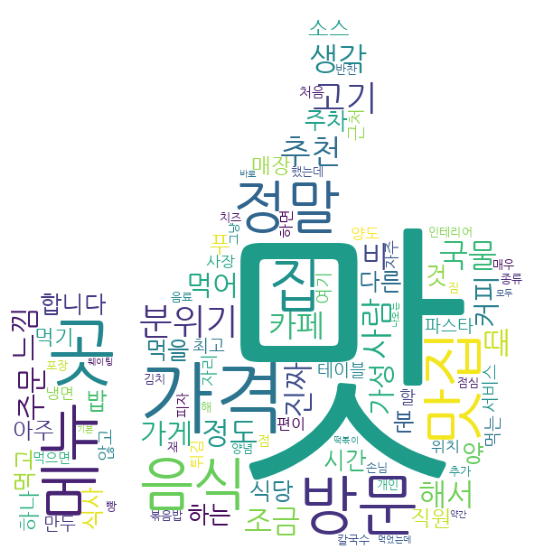

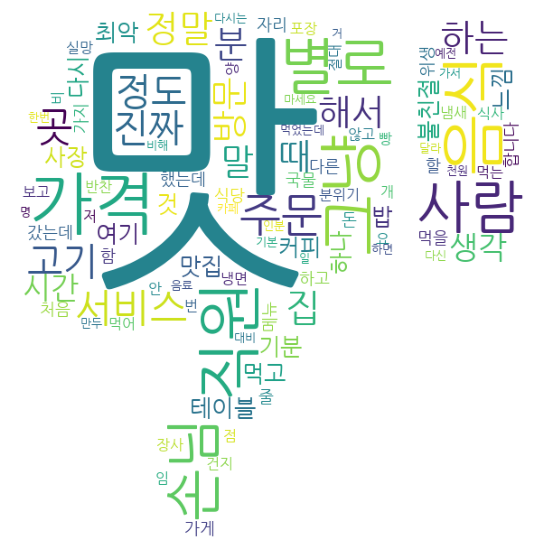

In [ ]:
# 시각화. Wordcloud

good_image = Image.open('good.png') 
bad_image = Image.open('bad.png')

good_mask = np.array(Image.open('good.png'))
bad_mask = np.array(Image.open('bad.png'))

# 한글 폰트 설정하기
font = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# WordClod 객체 만들기
good_wordcloud = WordCloud(font_path=font,
                           width=8000,
                           height=8000,
                           max_font_size=2000,
                           max_words=100,
                           background_color='white',
                           mask=good_mask)

bad_wordcloud = WordCloud(font_path=font,
                          width=8000,
                          height=8000,
                          max_font_size=2000,
                          max_words=100,
                          background_color='white',
                          mask=bad_mask)

# wordcloud 이미지 생성 및 출력
good_wordcloud.generate_from_frequencies(good_counts)

plt.figure(figsize=(7,7))
plt.imshow(good_wordcloud)
plt.axis('off')
plt.show()
print('='*100)



bad_wordcloud.generate_from_frequencies(bad_counts)

plt.figure(figsize=(7,7))
plt.imshow(bad_wordcloud)
plt.axis('off')
plt.show()